In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import skfuzzy as fz
from skfuzzy import control as ctrl
import math

In [32]:
#Setup variables for universe and their ranges
#Input with respect to object
distance = ctrl.Antecedent(np.arange(0, 10, 0.5), 'distance')
angle    = ctrl.Antecedent(np.arange(0, 90, 1), 'angle')

#Resulting action to take
speed = ctrl.Consequent(np.arange(0, 5, 0.2), 'speed')
steer  = ctrl.Consequent(np.arange(0, 90, 1), 'steer')

/home/pjaworsk/miniconda3/envs/flow/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


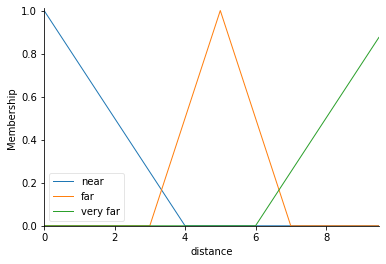

In [33]:

#Set up custom memberships for each variable and output
distance['near'] = fz.trimf(distance.universe, [0, 0, 4]) 
distance['far'] = fz.trimf(distance.universe,  [3, 5, 7]) 
distance['very far'] = fz.trimf(distance.universe,  [6, 10, 10])

#seems to be broken outside of using this in ipython. *smh*
distance.view()

/home/pjaworsk/miniconda3/envs/flow/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


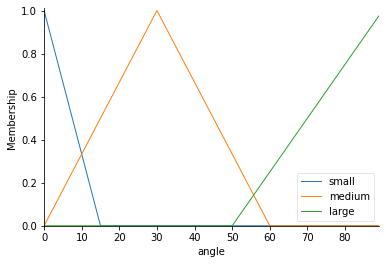

In [34]:

#Set up custom memberships for each variable and output
angle["small"] = fz.trimf(angle.universe, [0, 0, 15]) 
angle["medium"] = fz.trimf(angle.universe,  [0, 30, 60]) 
angle["large"] = fz.trimf(angle.universe,  [50, 90, 90])

#seems to be broken outside of using this in ipython.
angle.view()

/home/pjaworsk/miniconda3/envs/flow/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


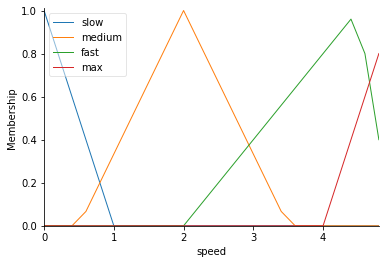

In [35]:

#Set up custom memberships for each variable and output
speed['slow'] = fz.trimf(speed.universe, [0, 0, 1]) 
speed['medium'] = fz.trimf(speed.universe,  [0.5, 2, 3.5]) 
speed['fast'] = fz.trimf(speed.universe,  [2, 4.5, 5])
speed['max'] = fz.trimf(speed.universe,  [4, 5, 5])

#seems to be broken outside of using this in ipython.
speed.view()

/home/pjaworsk/miniconda3/envs/flow/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


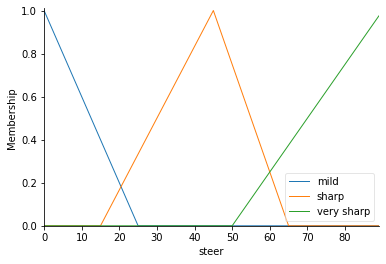

In [36]:
#Set up custom memberships for each variable and output
steer['mild'] = fz.trimf(steer.universe, [0, 0, 25]) 
steer['sharp'] = fz.trimf(steer.universe,  [15, 45, 65]) 
steer['very sharp'] = fz.trimf(steer.universe,  [50, 90, 90])


#seems to be broken outside of using this in ipython.
steer.view()

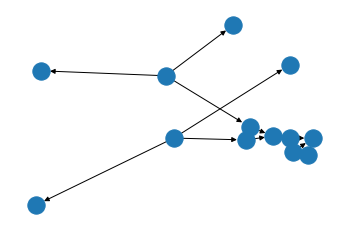

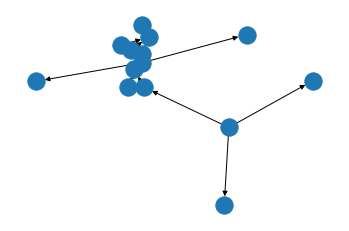

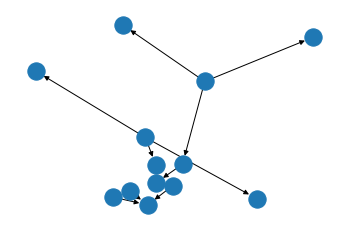

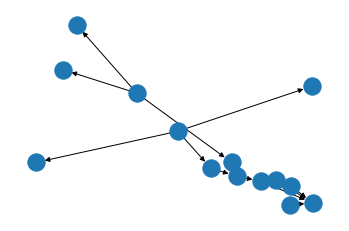

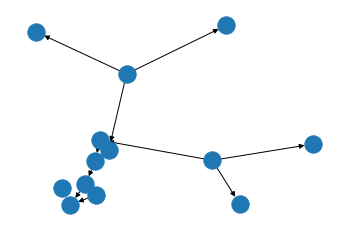

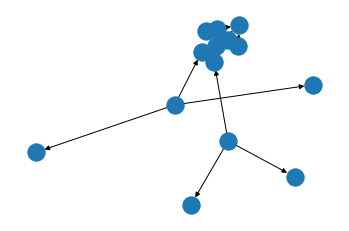

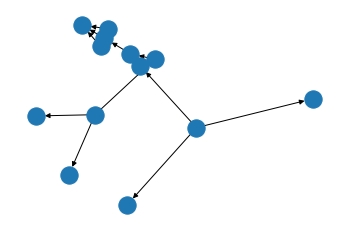

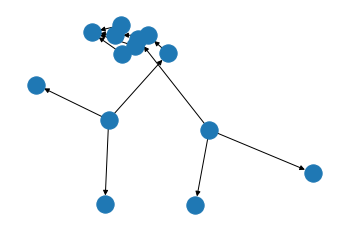

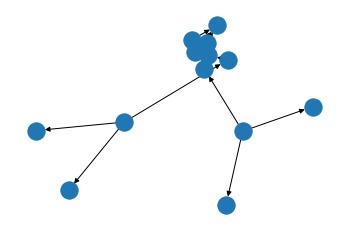

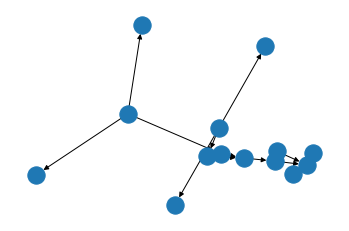

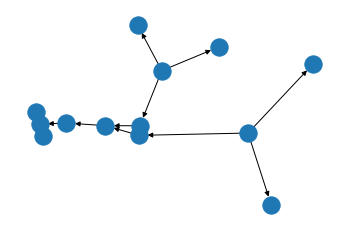

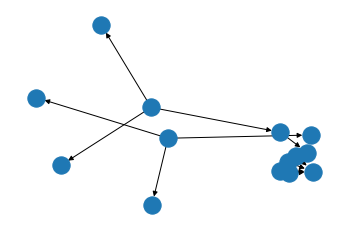

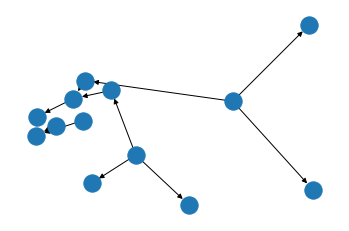

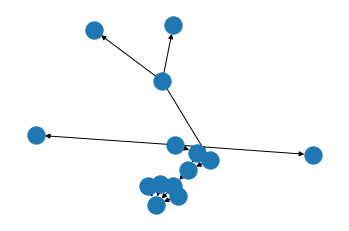

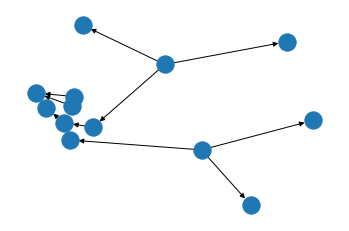

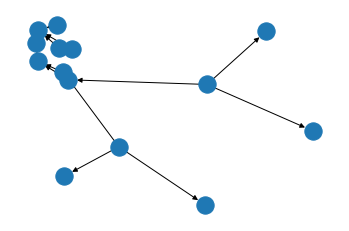

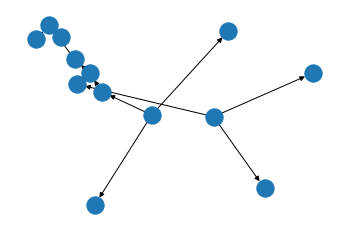

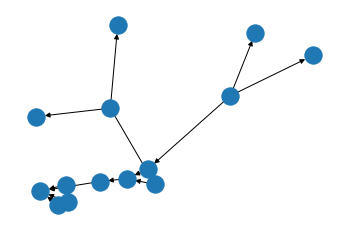

In [37]:
rules = []
rules.append(ctrl.Rule(distance['near'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['near'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['near'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['near'] & angle['small'], steer['very sharp']))
rules.append(ctrl.Rule(distance['near'] & angle['small'], speed['slow']))


rules.append(ctrl.Rule(distance['far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['far'] & angle['large'], speed['fast']))

rules.append(ctrl.Rule(distance['far'] & angle['medium'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['medium'], speed['medium']))

rules.append(ctrl.Rule(distance['far'] & angle['small'], steer['sharp']))
rules.append(ctrl.Rule(distance['far'] & angle['small'], speed['medium']))


rules.append(ctrl.Rule(distance['very far'] & angle['large'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['large'], speed['max']))

rules.append(ctrl.Rule(distance['very far'] & angle['medium'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['medium'], speed['fast']))

rules.append(ctrl.Rule(distance['very far'] & angle['small'], steer['mild']))
rules.append(ctrl.Rule(distance['very far'] & angle['small'], speed['medium']))

for rule in rules:
    rule.view()

In [95]:
ctrl_system = ctrl.ControlSystem(rules)
ctrl_sim = ctrl.ControlSystemSimulation(ctrl_system)

In [148]:
# ASSUMPTION 0: units are in meters, m/s, and degrees
# ASSUMPTION 1: control frequency is 100ms
# ASSUMPTION 2: start our speed and steering at 0
# ASSUMPTION 3: the environment is boundless (no walls)
# ASSUMPTION 4: we have one obstacle to avoid at a time
# ASSUMPTION 5: once we pass an obstacle (|ang| > 90) the next one is spawned
# ASSUMPTION 6: the obstacle spawns at a random distance from the robot between 1-11m
# ASSUMPTION 7: obstacles spawn at a random angle between -90 and 90
# ASSUMPTION 8: running sim for 10 seconds
# ASSUMPTION 9: assuming singleton input values

#ASSUMPTION 10: Robot starts at 0,0 in the global world frame
#ASSUMPTION 11: obstacles position and angle are mapped in the world frame
#ASSUMPTION 12: The front of the robot is used to determine the angle 0 relative to the world frame
#ASSUMPTION 13: The center of the robot is used as the point of reference for position calculations

dt = 0.1
runtime = 10 # seconds
steps = math.floor(runtime / dt)


speed = 0 
steer = 0
pos = [0, 0]
positions = []
positions.append(np.copy(pos))
obstacles = []
pos_at_target_change = []
steering_angles = []
steering_angles.append(np.copy(steer))
steering_angle_at_target_change = []

np.random.seed(0)

def deg_to_rad(deg):
    rad = deg*np.pi/180
    return rad

def rad_to_deg(rad):
    deg = rad*180/np.pi
    return deg

def gen_random_obstacle(pos, steer):
    # select a random angle between -90 to 90 instead of +- 90
    # this way our obstacles are a little more in the way
    ang = np.random.choice(np.arange(-90, 90, 1))
    # choose a random dist between 1 and 11
    dist = np.random.choice(np.arange(1, 11, 0.5))
    # make the target angle relative to the robot heading
    # this way it is +/-90 from our current heading, not behind us
    ang = ang + steer
    dx = np.cos(deg_to_rad(ang)) * dist
    dy = np.sin(deg_to_rad(ang)) * dist
    
    # remove small values from numerical limitations
    thres = 1e-10
    if abs(dx)<thres:
        dx = 0
    if abs(dy)<thres:
        dy=0

    obstacle = [pos[0] + dx, pos[1] + dy]
    return obstacle

def get_input(obstacle, pos, steer):
    # calculates the actual angle between robot and obstacle, and
    # the distance. These will be our simulated sensor values
    
    # vector from position to obstacle
    robot_to_obstacle = np.asarray(obstacle) - np.asarray(pos)
    # vector along which rover is moving
    dx = np.sin(deg_to_rad(steer))
    dy = np.cos(deg_to_rad(steer))
    future_pos = np.array([pos[0]+dx, pos[1]+dy])
    robot_to_steer = (future_pos - np.asarray(pos))
    
    unit_vec1 = robot_to_obstacle / np.linalg.norm(robot_to_obstacle)
    unit_vec2 = robot_to_steer / np.linalg.norm(robot_to_steer)
    dot = np.dot(unit_vec1, unit_vec2)
    ang = rad_to_deg(np.arccos(dot))

    dist = np.linalg.norm(np.asarray(pos)-np.asarray(obstacle))
    return dist, ang

def next_pos(steer, speed, pos, dt):
    # calculate the next robot position given the heading and speed
    step_size = speed * dt
    dx = np.sin(deg_to_rad(steer)) * step_size
    dy = np.cos(deg_to_rad(steer)) * step_size
    pos[0] += dx
    pos[1] += dy
    return pos

angle_sign = 1

for ii in range(steps):
    if (ii == 0):
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        pos_at_target_change.append(np.copy(pos))
        dist, ang = get_input(obstacle, pos, steer)
        steering_angle_at_target_change.append(np.copy(steer))
        obstacles.append(obstacle)

    # calculate our distance and angle to target to simulate our sensors
    dist, ang = get_input(obstacle, pos, steer)

    # our fuzzy system takes positive inputs, so store the sign here to restore it later
    angle_sign = np.sign(ang)

    if abs(ang) > 90:
        print(f"We have steered passed our target: theta = {ang}")
        obstacle = gen_random_obstacle(pos=pos, steer=steer)
        pos_at_target_change.append(np.copy(pos))
        steering_angle_at_target_change.append(np.copy(steer))
        obstacles.append(obstacle)
        dist, ang = get_input(obstacle, pos, steer)

    # run a step of our sim
    ctrl_sim.input['distance'] = dist
    ctrl_sim.input['angle'] = ang
    ctrl_sim.compute()

    # retrieve our control outputs
    speed = ctrl_sim.output['speed']
    # restore the sign of our angle so we know whether to turn left or right
    steer = angle_sign * ctrl_sim.output['steer']

    # calculte our updated position
    pos = next_pos(steer=steer, speed=speed, pos=pos, dt=dt)
    positions.append(np.copy(pos))
    steering_angles.append(np.copy(steer))

print('sim done')
print(steering_angle_at_target_change)

We have steered passed our target: theta = 93.499475349181
We have steered passed our target: theta = 94.46879989134986
We have steered passed our target: theta = 105.9277528789965
We have steered passed our target: theta = 93.65482106168211
We have steered passed our target: theta = 141.220994978444
We have steered passed our target: theta = 129.87733310846195
We have steered passed our target: theta = 92.68903495915421
We have steered passed our target: theta = 114.53882756953499
We have steered passed our target: theta = 124.74492446564459
We have steered passed our target: theta = 90.22686181415192
sim done
[array(0), array(10.45431831), array(41.13270361), array(10.15872773), array(10.95695392), array(8.44907407), array(9.72222222), array(11.34899637), array(9.18560606), array(9.72222222), array(8.66908807)]


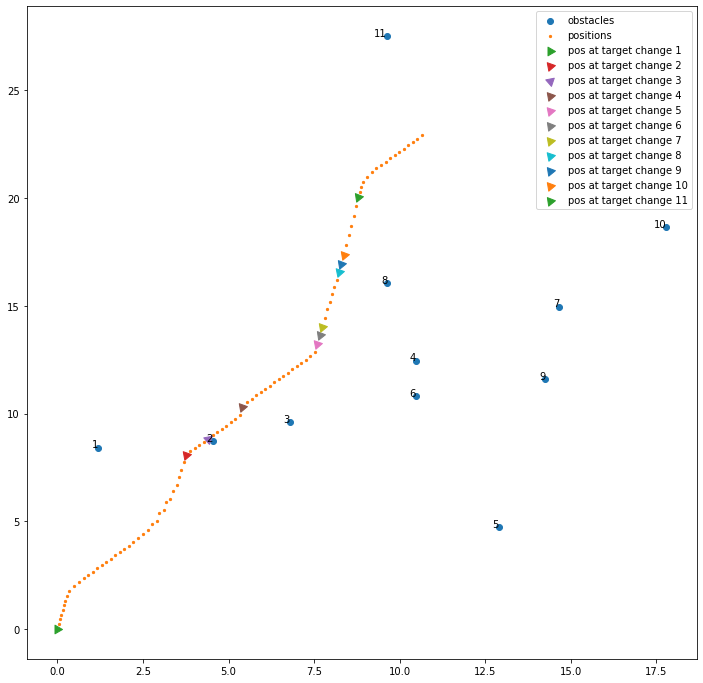

In [150]:
obstacles = np.asarray(obstacles)
positions = np.asarray(positions)
pos_at_target_change = np.asarray(pos_at_target_change)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(obstacles[:, 0], obstacles[:, 1], label='obstacles')
for ii, obstacle in enumerate(obstacles):
    plt.text(obstacle[0], obstacle[1], f"{ii+1}", horizontalalignment='right')
plt.scatter(positions[:, 0], positions[:, 1], label='positions', s=5)
for ii in range(0, len(pos_at_target_change)):
    plt.scatter(
        pos_at_target_change[ii, 0],
        pos_at_target_change[ii, 1],
        marker=(3, 0, steering_angle_at_target_change[ii]-90),
        s=100,
        label=f'pos at target change {ii+1}')

plt.legend()
plt.savefig('obstacle_avoidance.png')
plt.show()